<a href="https://colab.research.google.com/github/Axel0087/NLP2023/blob/main/week39%20lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load af Dataset og grundfunktioner

In [36]:
%%capture
!pip install datasets
!pip install bpemb

In [37]:
from torch.utils.data import DataLoader, Dataset
import nltk
from bpemb import BPEmb
import string
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch

In [38]:
dataset = load_dataset("copenlu/answerable_tydiqa")
nltk.download('punkt')

train_set = dataset["train"]
validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]

def get_answerble(dataset):
  return dataset.filter(lambda x: x["annotations"]["answer_start"] != [-1])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
vocab_size = 25000
encoding_dim = 100

bpemb_ar = BPEmb(lang='ar', dim=encoding_dim, vs=vocab_size)
bpemb_bn = BPEmb(lang='bn', dim=encoding_dim, vs=vocab_size)
bpemb_in = BPEmb(lang='id', dim=encoding_dim, vs=vocab_size)
bpemb_en = BPEmb(lang='en', dim=encoding_dim, vs=vocab_size)

### English

In [40]:
train_english = get_language(train_set, "english")
val_english = get_language(validation_set, "english")

In [41]:
train_english_answerble = get_answerble(train_english)

In [42]:
train_english_tt = train_english_answerble.train_test_split(test_size=0.2)

### language data

In [43]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

In [44]:
train_arabic_answerble = get_answerble(train_arabic)
val_arabic_answerble = get_answerble(val_arabic)

train_bengali_answerble = get_answerble(train_bengali)
val_bengali_answerble = get_answerble(val_bengali)

train_indonesian_answerble = get_answerble(train_indonesian)
val_indonesian_answerble = get_answerble(val_indonesian)

In [45]:
train_arabic_tt = train_arabic_answerble.train_test_split(test_size=0.2)
train_bengali_tt = train_bengali_answerble.train_test_split(test_size=0.2)
train_indonesian_tt = train_indonesian_answerble.train_test_split(test_size=0.2)

# Padding & datasetreader

In [46]:
def text_to_ids(text, tokenizer):
    input_ids = tokenizer.encode_ids(text)
    return input_ids, len(input_ids)

def pad_input(input):
    input_ids = [i[0] for i in input]
    seq_lens = [i[1] for i in input]
    answer_span_label = [i[2] for i in input]

    max_length = max(seq_lens)
    input_ids = [(i + [0] * (max_length - len(i))) for i in input_ids]
    label_ids = [(i + [0] * (max_length - len(i))) for i in answer_span_label]

    assert all(len(i) == max_length for i in input_ids)

    return (torch.tensor(input_ids),
        torch.tensor(seq_lens),
        torch.tensor(label_ids))


In [47]:
class DatasetReader(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        question = get_question(row)
        document = get_document(row)
        answer = get_answer(row)



        combined_question_document = question + ' <SEP> ' + document
        # Locate answer in document
        answer_start_char = combined_question_document.find(answer)
        if answer_start_char == -1:  # Answer not found in document
            raise ValueError("Answer not found in document.")

        input_ids, token_char_positions = self.text_to_ids_with_char_positions(combined_question_document)
        seq_lens = len(input_ids)

        # Convert character indices to token indices
        answer_start_token, answer_end_token = self.char_to_token_indices(answer_start_char, answer, token_char_positions)

        label_sequence = [0] * len(input_ids)
        if answer_start_token != -1 and answer_end_token != -1:
            label_sequence[answer_end_token] = 2    # Mark end of answer
            for i in range(answer_start_token,answer_end_token ):
              label_sequence[i] = 2
            for i in range(answer_end_token, answer_start_token):
              label_sequence[i] = 2

            label_sequence[answer_start_token] = 1  # Mark start of answer

        return input_ids, seq_lens, label_sequence

    def text_to_ids_with_char_positions(self, text):
        """
        Tokenize the text and return token ids along with character start positions for each token.
        """
        input_ids, seq_lens = text_to_ids(text, self.tokenizer)

        tokens = self.tokenizer.encode(text)
       # input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
       # print(tokens)
        token_char_positions = []
        char_position = 0
        for token in tokens:
            token_char_positions.append(char_position)
            char_position += len(token.replace("##", ""))  # Adjust for BPE '##' prefix on subwords

        return input_ids, token_char_positions

    def char_to_token_indices(self, start_char, answer, token_char_positions):
        """
        Convert character-level indices of the answer to token-level indices.
        """
        end_char = start_char + len(answer) - 1

        start_token = next((i for i, pos in enumerate(token_char_positions) if pos >= start_char), -1)
        end_token = next((i for i, pos in enumerate(token_char_positions) if pos > end_char), -1) - 1

        return start_token, end_token

In [ ]:
print(bpemb_ar.encode('القطائع'))
bpemb_ar.encode_ids('القطائع')

['▁القط', 'ائع']


[2621, 2573]

In [ ]:
print(bpemb_ar.encode('Coordinates: \nالقطائع هي المدينة التي بناها أحمد بن طولون في مصر لتكون عاصمته، بدأ في تاسيسها في شعبان سنة (256هـ) وظلت عاصمة مصر طول العصر الطولونى.'))
bpemb_ar.encode_ids('Coordinates: \nالقطائع هي المدينة التي بناها أحمد بن طولون في مصر لتكون عاصمته، بدأ في تاسيسها في شعبان سنة (256هـ) وظلت عاصمة مصر طول العصر الطولونى.')


['▁co', 'ord', 'in', 'ates', ':', '▁', '\n', 'ال', 'قط', 'ائع', '▁هي', '▁المدينة', '▁التي', '▁بناها', '▁أحمد', '▁بن', '▁طول', 'ون', '▁في', '▁مصر', '▁لتكون', '▁عاصم', 'ته', '،', '▁بدأ', '▁في', '▁ت', 'اسيس', 'ها', '▁في', '▁شعبان', '▁سنة', '▁(000', 'ه', 'ـ)', '▁وظلت', '▁عاصمة', '▁مصر', '▁طول', '▁العصر', '▁الطول', 'ون', 'ى', '.']


[7070,
 3312,
 255,
 10734,
 24907,
 24875,
 0,
 3,
 495,
 2573,
 193,
 676,
 132,
 22231,
 1013,
 139,
 1474,
 31,
 14,
 822,
 6209,
 13799,
 166,
 24901,
 700,
 14,
 9,
 11550,
 30,
 14,
 10935,
 254,
 2107,
 24892,
 7417,
 15180,
 3329,
 822,
 1474,
 2214,
 8419,
 31,
 24903,
 24898]

    
    if self.direction == 'forward':
      answer_end = answer_start + len(answer_ids)
    if self.direction == 'backwards':
      answer_end = answer_start - len(answer_ids)  
    else:
      answer_end= -1

    answer_span = [answer_start, answer_end]


In [ ]:
D_reader = DatasetReader(train_english_tt['train'],bpemb_en)

In [ ]:
train_english_tt['train'][0]

{'question_text': 'When was Lithuania founded?',
 'document_title': 'History of Lithuania',
 'language': 'english',
 'annotations': {'answer_start': [3], 'answer_text': ['February 16, 1918']},
 'document_plaintext': 'On February 16, 1918, Lithuania was re-established as a democratic state. It remained independent until the outset of World War II, when it was occupied by the Soviet Union under the terms of the Molotov–Ribbentrop Pact. Following a brief occupation by Nazi Germany after the Nazis waged war on the Soviet Union, Lithuania was again absorbed into the Soviet Union for nearly 50 years. In 1990–1991, Lithuania restored its sovereignty with the Act of the Re-Establishment of the State of Lithuania. Lithuania joined the NATO alliance in 2004 and the European Union as part of its enlargement in 2004.',
 'document_url': 'https://en.wikipedia.org/wiki/History%20of%20Lithuania'}

In [ ]:
D_reader[0]

['▁when', '▁was', '▁lithuania', '▁founded', '?', '▁', '<', 'se', 'p', '>', '▁on', '▁february', '▁00,', '▁0000,', '▁lithuania', '▁was', '▁re', '-', 'established', '▁as', '▁a', '▁democratic', '▁state', '.', '▁it', '▁remained', '▁independent', '▁until', '▁the', '▁out', 'set', '▁of', '▁world', '▁war', '▁ii', ',', '▁when', '▁it', '▁was', '▁occupied', '▁by', '▁the', '▁soviet', '▁union', '▁under', '▁the', '▁terms', '▁of', '▁the', '▁mol', 'ot', 'ov', '–', 'rib', 'bent', 'rop', '▁pact', '.', '▁following', '▁a', '▁brief', '▁occupation', '▁by', '▁nazi', '▁germany', '▁after', '▁the', '▁nazis', '▁w', 'aged', '▁war', '▁on', '▁the', '▁soviet', '▁union', ',', '▁lithuania', '▁was', '▁again', '▁absorbed', '▁into', '▁the', '▁soviet', '▁union', '▁for', '▁nearly', '▁00', '▁years', '.', '▁in', '▁0000–0000,', '▁lithuania', '▁restored', '▁its', '▁sovereignty', '▁with', '▁the', '▁act', '▁of', '▁the', '▁re', '-', 'establish', 'ment', '▁of', '▁the', '▁state', '▁of', '▁lithuania', '.', '▁lithuania', '▁joined', '▁

([391,
  73,
  11738,
  2027,
  24967,
  24912,
  0,
  144,
  24929,
  0,
  71,
  1394,
  419,
  162,
  11738,
  73,
  50,
  24940,
  12602,
  79,
  4,
  3220,
  614,
  24935,
  107,
  2306,
  2364,
  796,
  7,
  371,
  3822,
  27,
  501,
  430,
  964,
  24934,
  391,
  107,
  73,
  4933,
  101,
  7,
  2411,
  1527,
  400,
  7,
  2649,
  27,
  7,
  5545,
  85,
  188,
  24949,
  514,
  20424,
  1127,
  15411,
  24935,
  939,
  4,
  3284,
  6771,
  101,
  6647,
  2047,
  297,
  7,
  14898,
  15,
  2491,
  430,
  71,
  7,
  2411,
  1527,
  24934,
  11738,
  73,
  594,
  10902,
  423,
  7,
  2411,
  1527,
  72,
  3210,
  39,
  472,
  24935,
  26,
  7162,
  11738,
  6261,
  268,
  11996,
  97,
  7,
  368,
  27,
  7,
  50,
  24940,
  18086,
  187,
  27,
  7,
  614,
  27,
  11738,
  24935,
  11738,
  2300,
  7,
  10451,
  4563,
  26,
  52,
  34,
  7,
  1770,
  1527,
  79,
  252,
  27,
  268,
  10784,
  5418,
  26,
  220],
 129,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,


In [ ]:
j =0
s=0
e=0
for i in range(len(D_reader)):
  if (sum(D_reader[i][2])==0):
    j+=1
  if (sum(D_reader[i][2])==1):
    s+=1
  if (sum(D_reader[i][2])==2):
    e+=1

In [ ]:
print(j,s,e)

1 699 0


In [ ]:
train_dl = DataLoader(D_reader, batch_size=3, shuffle=False, collate_fn=pad_input)


In [ ]:
next(iter(train_dl))


(tensor([[  391,    73,  2916,  4459,   359,   266,   483,    26,  4729, 24967,
          24912,     0,   144, 24929,     0,     4,  4402,  5769,    72,  2702,
           2916, 24919,   732,  2237,    80,     4, 19843,    27,  2130,  2155,
           3223,    51,   416,   234,  2991, 24932,   174, 15830,     0,    11,
              0,    42,  3130, 17510,  5107, 11750,    27,  2942, 24934,  3577,
            101,   585,  9529,  4138, 22925,    26,    52,     0,    11,     0,
             34,  1144,  4402, 24940,    19, 10606,  2916,  4459,   359, 24935,
            215,  4402,  2702, 13686,   576,  1228,    80,  3916,   844,   483,
           1998,     7,   501, 24934,     0,    11,     0,    26,  1655,    72,
          17510,   139, 12319,  2237,    26,     7,   593,   590,    34,    72,
           2916,  4459,   359,  9724,   938,    26,  1019,    34,  3927, 24935,
           2500,  2500,  2500,  2500,  2500,  2500,  2500,  2500,  2500,  2500,
           2500,  2500,  2500,  2500,  2

#eksempel

In [ ]:
D_reader = DatasetReader(train_english,bpemb_en)

In [ ]:
train_english[0]

{'question_text': 'When was quantum field theory developed?',
 'document_title': 'Quantum field theory',
 'language': 'english',
 'annotations': {'answer_start': [159], 'answer_text': ['1920s']},
 'document_plaintext': 'Quantum field theory naturally began with the study of electromagnetic interactions, as the electromagnetic field was the only known classical field as of the 1920s.[8]:1',
 'document_url': 'https://en.wikipedia.org/wiki/Quantum%20field%20theory'}

In [ ]:
D_reader[0]

([391,
  73,
  8062,
  1316,
  2355,
  1818,
  24967,
  24912,
  0,
  144,
  24929,
  0,
  8062,
  1316,
  2355,
  10284,
  1046,
  97,
  7,
  2147,
  27,
  15236,
  11715,
  24934,
  79,
  7,
  15236,
  1316,
  73,
  7,
  491,
  646,
  4219,
  1316,
  79,
  27,
  7,
  52,
  24920,
  24935,
  0,
  24925,
  0,
  11005],
 44,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0])

#Model

In [48]:
from torch import nn

In [49]:
# Define the model
class BiLSTM(nn.Module):
    """
    Basic BiLSTM-CRF network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTM, self).__init__()
        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1), # padding_idx=3
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],  # input size
                lstm_dim,  # hidden size
                2,  # number of layers
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes),
        })
        self.n_classes = n_classes
        self.loss = nn.CrossEntropyLoss()
        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, hidden_states = None, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN - https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        if hidden_states:
            lstm_out, hidden = self.model['bilstm'](lstm_in, hidden_states)
        else:
            lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out, lengths = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Get logits (b x seq_len x n_classes)
        logits = self.model['ff'](lstm_out)
        outputs = (logits, lengths)
        if labels is not None:
            loss = self.loss(logits.reshape(-1, self.n_classes), labels.reshape(-1))
            outputs =  outputs + (loss,)
        return outputs

In [50]:
from tqdm import tqdm_notebook as tqdm

In [51]:
from sklearn.metrics import precision_recall_fscore_support


In [52]:
from sklearn.metrics import confusion_matrix


#Evaluate

In [53]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :return: The accuracy of the model on the dataset
    """
    # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
    # layer normalization and dropout
    model.eval()
    labels_all = []
    preds_all = []

    # ALSO IMPORTANT: Don't accumulate gradients during this process
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            seq_lens = batch[1]
            labels = batch[2]
            hidden_states = None

            logits, _, _ = model(input_ids, seq_lens, hidden_states=hidden_states, labels=labels)
           # print(logits.size())
            preds_all.extend(torch.argmax(logits, dim=-1).reshape(-1).detach().cpu().numpy())
            #print(torch.argmax(logits, dim=-1))
            #print(torch.argmax(logits, dim=-1)[0])
            #print(len(torch.argmax(logits, dim=-1)[0]))

            #print(torch.argmax(logits, dim=-1).size())
            #print(len(preds_all))
            #print(sum(preds_all))
            labels_all.extend(labels.reshape(-1).detach().cpu().numpy())
   #print(preds_all)
    P, R, F1, _ = precision_recall_fscore_support(labels_all, preds_all, average='macro')
    #print(confusion_matrix(labels_all, preds_all))
    return F1

# train

In [61]:
def train(
    model: nn.Module,
    train_dl: DataLoader,
    valid_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    device: torch.device,
    scheduler=None,
):
    """
    The main training loop which will optimize a given model on a given dataset
    :param model: The model being optimized
    :param train_dl: The training dataset
    :param valid_dl: A validation dataset
    :param optimizer: The optimizer used to update the model parameters
    :param n_epochs: Number of epochs to train for
    :param device: The device to train on
    :return: (model, losses) The best model and the losses per iteration
    """

  # Keep track of the loss and best accuracy
    losses = []
    learning_rates = []
    best_f1 = 0.0

    # Iterate through epochs
    for ep in range(n_epochs):

        print(ep)
        loss_epoch = []

        #Iterate through each batch in the dataloader
        for batch in tqdm(train_dl):
            # VERY IMPORTANT: Make sure the model is in training mode, which turns on
            # things like dropout and layer normalization
            model.train()

            # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
            # keeps track of these dynamically in its computation graph so you need to explicitly
            # zero them out
            optimizer.zero_grad()

            # Place each tensor on the GPU
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            seq_lens = batch[1]
            labels = batch[2]
           # print(labels.sum())
            #print('label')
            #print(labels)
            # Pass the inputs through the model, get the current loss and logits
            logits, lengths, loss = model(input_ids, seq_lens, labels=labels)
            losses.append(loss.item())
            loss_epoch.append(loss.item())

            # Calculate all of the gradients and weight updates for the model
            loss.backward()

            # Optional: clip gradients
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Finally, update the weights of the model
            optimizer.step()
            if scheduler != None:
                scheduler.step()
                learning_rates.append(scheduler.get_last_lr()[0])

        # Perform inline evaluation at the end of the epoch
        f1 = evaluate(model, valid_dl)
        print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

        # Keep track of the best model based on the accuracy
        if f1 > best_f1:
            torch.save(model.state_dict(), 'best_model')
            best_f1 = f1

    model.load_state_dict(torch.load('best_model'))
    return model,losses, learning_rates

In [55]:
from torch.optim import Adam

In [56]:
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR


# training on dataset

In [57]:
results = {}

In [ ]:
# Define some hyperparameters
batch_size =64
lr = 0.001
n_epochs = 100

# Define a default lstm_dim
lstm_dim = 300


runs = [#("English", train_english_tt, bpemb_en)
      # ("Arabic", train_arabic_tt, bpemb_ar)
       # ("Bengali", train_bengali_tt, bpemb_bn),
         ("Indonesian", train_indonesian_tt, bpemb_in)
]

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")


print(device)
for (tag, ds, embs) in runs:
  pretrained_embeddings = np.concatenate([embs.emb.vectors, np.zeros(shape=(1,100))], axis=0)

  # Create the model
  model = BiLSTM(pretrained_embeddings=torch.FloatTensor(pretrained_embeddings),
                        lstm_dim=lstm_dim,
                        dropout_prob=0.1,
                        n_classes=3).to(device)

  train_reader = DatasetReader(ds['train'], embs)
  train_dl  = DataLoader(train_reader, batch_size=batch_size, collate_fn=pad_input, shuffle=True, num_workers=8)
  optimizer = Adam(model.parameters(), lr=lr)

  #valid_reader = DatasetReader(ds['test'], embs,stop)
  #valid_dl = DataLoader(valid_reader, batch_size=len(ds['test']), collate_fn=pad_input, num_workers=8)
  valid_reader = DatasetReader(ds['test'], embs)
  valid_dl = DataLoader(valid_reader, batch_size=512, collate_fn=pad_input, num_workers=8)
  scheduler = CyclicLR(optimizer, base_lr=0., max_lr=lr, step_size_up=1, step_size_down=len(train_dl)*n_epochs, cycle_momentum=False)

  best_model, losses, learning_rates = train(model, train_dl, valid_dl, optimizer, n_epochs, device,scheduler)


  results[tag] = [losses, best_model]

cuda
0


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <function _ConnectionBase.__del__ at 0x795c1bdb7250>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessin

  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.333382977150193, train loss: 0.8101920344763331
1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.43598100544654805, train loss: 0.7210836468471421
2


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.43970827563108755, train loss: 0.6648731943633821
3


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.4108701322286447, train loss: 0.614306665956974
4


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.4895146029455864, train loss: 0.5664355506499609
5


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5279214429022671, train loss: 0.5243283965521388
6


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.4486631607560678, train loss: 0.4833291131589148
7


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5462092497208767, train loss: 0.4495658642715878
8


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5358053627624991, train loss: 0.4165336626271407
9


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5228642882608927, train loss: 0.38933627555767697
10


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5872390028616489, train loss: 0.36383049562573433
11


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6082720104661705, train loss: 0.3346172020667129
12


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5997251001060294, train loss: 0.31468059453699326
13


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5939906329224512, train loss: 0.29680970559517544
14


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6151372742246367, train loss: 0.27677272591325974
15


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6183730124742469, train loss: 0.25750728510320187
16


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5786871983602538, train loss: 0.24039632909827763
17


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.5980111176889094, train loss: 0.22599466000166205
18


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6203235674484715, train loss: 0.21046098094019625
19


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6507005268778737, train loss: 0.200268373100294
20


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6444901354780841, train loss: 0.1868971431006988
21


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.65258594429309, train loss: 0.174275741705464
22


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6531959616614279, train loss: 0.16603749183317026
23


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6481023707944623, train loss: 0.15600363951590326
24


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6713666168148117, train loss: 0.14731951689140665
25


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6773557714256091, train loss: 0.13816108275204897
26


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6669772081172224, train loss: 0.1320570410332746
27


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.665092649920345, train loss: 0.12439228780567646
28


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6687417911488082, train loss: 0.12702254061069754
29


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6742403292681421, train loss: 0.11522338104744752
30


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6710507266506905, train loss: 0.10847928209437264
31


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6763773035143323, train loss: 0.10401599347177479
32


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6843108575864352, train loss: 0.09690969116571876
33


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6809453457193517, train loss: 0.09297828407337268
34


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6839723868066722, train loss: 0.08869099244475365
35


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6824421033988983, train loss: 0.08490086408952872
36


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6868121443581874, train loss: 0.08014658403893311
37


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6733162036907553, train loss: 0.07821413884974188
38


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.680562670796296, train loss: 0.07548659729460876
39


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6830380931738315, train loss: 0.07247441293050845
40


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6855754223475664, train loss: 0.06886642415904337
41


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6818261579239046, train loss: 0.0663552404795256
42


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6823821158419209, train loss: 0.0637148203742173
43


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.684929212816657, train loss: 0.061077048950311214
44


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6863684133016484, train loss: 0.058857929064995713
45


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6859455654874523, train loss: 0.0576975057936377
46


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6799952738760142, train loss: 0.054622766096144915
47


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6833065855185723, train loss: 0.05282431059620447
48


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6837629057994374, train loss: 0.051461081175754465
49


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.683128786851981, train loss: 0.050236066751596004
50


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.672302507640533, train loss: 0.04872177111812764
51


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6822199457188676, train loss: 0.048663625597125955
52


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6785850529884385, train loss: 0.04782347665685746
53


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6877195558421931, train loss: 0.04584532562229368
54


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6846422710099862, train loss: 0.04279771881798903
55


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6836761290191481, train loss: 0.0412308227063881
56


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6860093993313088, train loss: 0.040424337714082666
57


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6860582173402845, train loss: 0.039015854734720454
58


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6883284045011343, train loss: 0.03808261091924376
59


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6895716150692367, train loss: 0.03754848754033446
60


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.686509725522524, train loss: 0.03660748663565351
61


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.69021953791268, train loss: 0.03556703734729025
62


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6888630350008084, train loss: 0.03472188040096727
63


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.685210410325977, train loss: 0.03357853486927019
64


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6775390745924262, train loss: 0.033807145405767694
65


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6828697307036581, train loss: 0.033337428751919
66


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6861875529008351, train loss: 0.03203246923577455
67


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6831606385577214, train loss: 0.031013641247732773
68


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6880850860041443, train loss: 0.030232148063886497
69


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.686724662335671, train loss: 0.02952015700025691
70


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6834053258446214, train loss: 0.029124275030982163
71


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6859181762940797, train loss: 0.028654613609736163
72


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6874594621720758, train loss: 0.027695320080965757
73


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6798686576986054, train loss: 0.02706339202510814
74


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6850817695467611, train loss: 0.026650918983957834
75


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6810622397993114, train loss: 0.02639991148478455
76


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6839482533596857, train loss: 0.025945743106098637
77


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6849321221576709, train loss: 0.024904604328589305
78


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6860926546449949, train loss: 0.024991348541031282
79


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6858494336131088, train loss: 0.024293092894367874
80


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-53-6f3d50efb50b>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Validation F1: 0.6854708171758679, train loss: 0.023878932050946686
81


<ipython-input-61-11f6c435cd18>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_dl):


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
learning_rates

[0.0009999999999998053,
 0.000999925925925926,
 0.0009998518518518518,
 0.0009997777777777778,
 0.0009997037037037038,
 0.0009996296296296298,
 0.0009995555555555556,
 0.0009994814814814814,
 0.0009994074074074074,
 0.0009993333333333334,
 0.0009992592592592592,
 0.0009991851851851852,
 0.000999111111111111,
 0.000999037037037037,
 0.000998962962962963,
 0.000998888888888889,
 0.0009988148148148148,
 0.0009987407407407408,
 0.0009986666666666668,
 0.0009985925925925928,
 0.0009985185185185186,
 0.0009984444444444446,
 0.0009983703703703704,
 0.0009982962962962962,
 0.0009982222222222222,
 0.0009981481481481482,
 0.000998074074074074,
 0.000998,
 0.000997925925925926,
 0.000997851851851852,
 0.0009977777777777778,
 0.0009977037037037038,
 0.0009976296296296296,
 0.0009975555555555556,
 0.0009974814814814816,
 0.0009974074074074076,
 0.0009973333333333334,
 0.0009972592592592594,
 0.0009971851851851852,
 0.0009971111111111112,
 0.000997037037037037,
 0.000996962962962963,
 0.000996888888

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
results

{'Bengali': [[0.6973391175270081,
   0.6970451474189758,
   0.6870540976524353,
   0.6677886843681335,
   0.6242232322692871,
   0.6000495553016663,
   0.5997381210327148,
   0.5787291526794434,
   0.479609876871109,
   0.5067973136901855,
   0.48570555448532104,
   0.5241670608520508,
   0.5492305755615234,
   0.5610325932502747,
   0.49630334973335266,
   0.4627548158168793,
   0.5351399183273315,
   0.470242977142334,
   0.4732394516468048,
   0.5626974701881409,
   0.5767391920089722,
   0.5264883041381836,
   0.48505792021751404,
   0.4710055887699127,
   0.38412633538246155,
   0.4685848355293274,
   0.5545088052749634,
   0.41174226999282837,
   0.40871110558509827,
   0.4628112316131592,
   0.4525080919265747,
   0.47485342621803284,
   0.5416079759597778,
   0.41712653636932373,
   0.4128384590148926,
   0.49423038959503174,
   0.4590625464916229,
   0.5375159382820129,
   0.51887047290802,
   0.4779224693775177,
   0.4723641276359558,
   0.604664146900177,
   0.55739957094192

In [ ]:
runs = [#("English", train_english_tt, bpemb_en,english_removal_list),
        #("Arabic", train_arabic_tt, val_arabic, bpemb_ar,arabic_removal_list)
        ("Bengali", train_bengali_tt,val_bengali, bpemb_bn)
        # ("Indonesian", train_indonesian_tt,val_indonesian, bpemb_in, indonesian_removal_list),
]
for (tag, ds,ds_val, embs) in runs:
  print(tag)


  # Create the dataset readers
  val_dataset = DatasetReader(ds_val, embs)
# dataset loaded lazily with N workers in parallel
  val_dl = DataLoader(val_dataset, batch_size=512, collate_fn=pad_input, num_workers=8)

  test_reader = DatasetReader(ds['test'], embs)
  test_dl = DataLoader(test_reader, batch_size=512, collate_fn=pad_input, num_workers=8)

  val_acc = evaluate(results[tag][1], val_dl)
  test_acc = evaluate(results[tag][1], test_dl)

  print(f"Valiation accuracy for {tag}: {val_acc}")
  print(f"Test accuracy for {tag}: {test_acc}")


Bengali


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-26-e761a07d6fb5>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173

174175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
[[189645    132]
 [   314     85]]


<ipython-input-26-e761a07d6fb5>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(valid_dl, desc='Evaluation'):


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

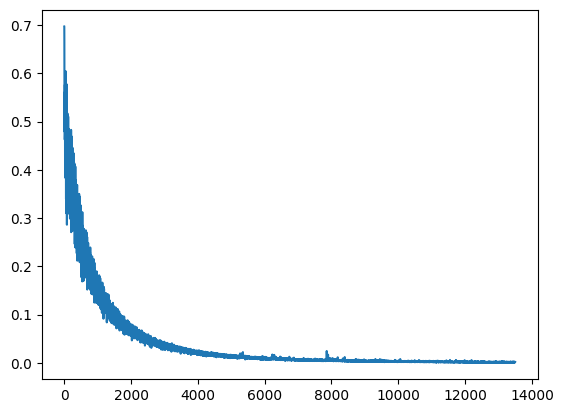

In [ ]:
  plt.plot(results['Bengali'][0])

In [ ]:
  plt.plot(results['Bengali'][0])

In [ ]:
  plt.plot(results['Indonesian'][0])

In [ ]:
labels = [val_dataset[x][2] for x in range(len(val_dataset))]


In [ ]:
total_sum = sum(labels)
total_sum

951

In [ ]:
len(val_dataset)

1902

# Transformer

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.label_, ent.text))
    return entities

In [ ]:
print(extract_entities(train_english[1]['document_plaintext']))

In [ ]:
%%capture
!pip3 install transformers

In [ ]:
from transformers import AutoTokenizer, BertForMaskedLM

In [ ]:
!pip install datasets transformers evaluate

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = BertForMaskedLM.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_english[1]

{'question_text': 'Who was the first Nobel prize winner for Literature?',
 'document_title': 'List of Nobel laureates in Literature',
 'language': 'english',
 'annotations': {'answer_start': [610], 'answer_text': ['Sully Prudhomme']},
 'document_plaintext': "The Nobel Prize in Literature (Swedish: Nobelpriset i litteratur) is awarded annually by the Swedish Academy to authors for outstanding contributions in the field of literature. It is one of the five Nobel Prizes established by the 1895 will of Alfred Nobel, which are awarded for outstanding contributions in chemistry, physics, literature, peace, and physiology or medicine.[1] As dictated by Nobel's will, the award is administered by the Nobel Foundation and awarded by a committee that consists of five members elected by the Swedish Academy.[2] The first Nobel Prize in Literature was awarded in 1901 to Sully Prudhomme of France.[3] Each recipient receives a medal, a diploma and a monetary award prize that has varied throughout the 

In [ ]:
liste_tok = tokenizer.encode(train_english[1]['document_plaintext'])

In [ ]:
for i in liste_tok:
  print(tokenizer._convert_id_to_token(i))
#print(tokenizer._convert_id_to_token(1332))

[CLS]
The
Nobel
Prize
in
Literature
(
Swedish
:
Nobel
##prise
##t
i
litter
##at
##ur
)
is
awarded
annually
by
the
Swedish
Academy
to
authors
for
outstanding
contributions
in
the
field
of
literature
.
It
is
one
of
the
five
Nobel
Prize
##s
established
by
the
1895
will
of
Alfred
Nobel
,
which
are
awarded
for
outstanding
contributions
in
chemistry
,
physics
,
literature
,
peace
,
and
physiology
or
medicine
.
[
1
]
As
dictated
by
Nobel
'
s
will
,
the
award
is
administered
by
the
Nobel
Foundation
and
awarded
by
a
committee
that
consists
of
five
members
elected
by
the
Swedish
Academy
.
[
2
]
The
first
Nobel
Prize
in
Literature
was
awarded
in
1901
to
Sul
##ly
P
##rud
##hom
##me
of
France
.
[
3
]
Each
recipient
receives
a
medal
,
a
diploma
and
a
monetary
award
prize
that
has
varied
throughout
the
years
.
[
4
]
In
1901
,
P
##rud
##hom
##me
received
150
,
78
##2
SE
##K
,
which
is
equivalent
to
8
,
82
##3
,
63
##7
.
78
SE
##K
in
January
2018
.
The
award
is
presented
in
Stockholm
at
an
annual
cerem

In [ ]:
tokenizer(train_english[1]['question_text'])

{'input_ids': [101, 2627, 1108, 1103, 1148, 10412, 4716, 2981, 1111, 7594, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer(train_english[1]['question_text'])

{'input_ids': [101, 2627, 1108, 1103, 1148, 10412, 4716, 2981, 1111, 7594, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}